<a href="https://colab.research.google.com/github/hbaflast/bert-sentiment-analysis-pytorch/blob/master/bert_sentiment_analysis_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert Sentiment Analysis - PyTorch

## Import

In [0]:
# Install missing librairies
!pip install transformers

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import (BertTokenizer, BertForSequenceClassification,
                          CamembertTokenizer, CamembertForSequenceClassification)

In [0]:
plt.rcParams["figure.figsize"] = (16, 9)

In [4]:
# check gpu
!nvidia-smi

Fri Feb 21 15:57:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load data

### Kaggle creadentials

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [7]:
!kaggle datasets download hbaflast/french-twitter-sentiment-analysis

 83% 40.0M/48.3M [00:00<00:00, 56.6MB/s]
100% 48.3M/48.3M [00:00<00:00, 70.9MB/s]


### Read dataset

In [0]:
df_dataset = pd.read_csv("/content/french-twitter-sentiment-analysis.zip", sep=',')

In [0]:
df_dataset = df_dataset.sample(frac=0.1, random_state=42)  # sample to speed-up computation

In [10]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152672 entries, 471040 to 126980
Data columns (total 2 columns):
label    152672 non-null int64
text     152672 non-null object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


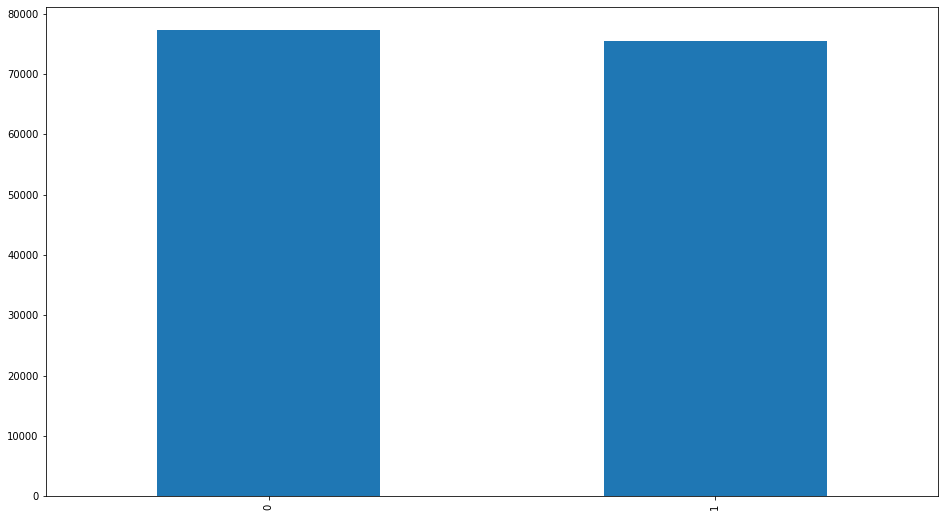

In [11]:
df_dataset['label'].value_counts().plot.bar();

## Text length distribution

In [12]:
df_dataset['sent_len'] = df_dataset['text'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(df_dataset['sent_len'].mean() + 2 * df_dataset['sent_len'].std()).astype(int)
max_seq_len

30

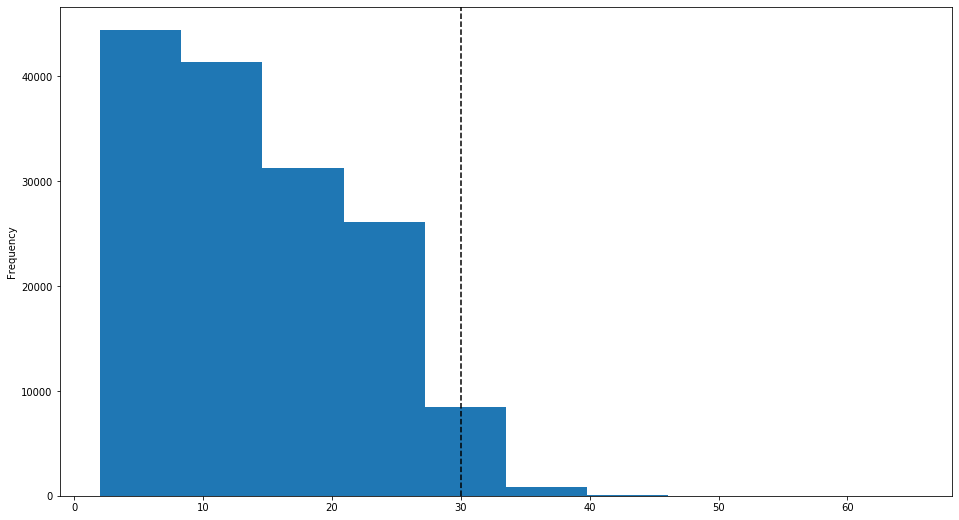

In [13]:
df_dataset['sent_len'].plot.hist()
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len');

## Load tokenizer

In [14]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [15]:
tokenizer.tokenize("J'aime bien faire des achats en ligne")

['▁J', "'", 'aime', '▁bien', '▁faire', '▁des', '▁achats', '▁en', '▁ligne']

In [16]:
tokenizer.encode("J'aime bien faire des achats en ligne")

[5, 121, 11, 660, 72, 85, 20, 5503, 22, 284, 6]

## Load transformers model

In [17]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=2)

In [18]:
model.to(device)

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

## Process input example

In [19]:
input_ = torch.tensor(tokenizer.encode("J'aime bien faire des achats en ligne")).unsqueeze(0).to(device)
input_

tensor([[   5,  121,   11,  660,   72,   85,   20, 5503,   22,  284,    6]],
       device='cuda:0')

In [20]:
label = torch.tensor([0]).unsqueeze(0).to(device)
label

tensor([[0]], device='cuda:0')

In [21]:
logits = model.eval()(input_ids=input_)
logits

(tensor([[-0.0898,  0.1546]], device='cuda:0', grad_fn=<AddmmBackward>),)

In [22]:
output = F.softmax(logits[0], dim=1)
output

tensor([[0.4392, 0.5608]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Pre-processing

### Tokenize text & padding

In [23]:
df_dataset.head()

,label,text,sent_len
471040,0,El som et la société humaine avec cindy! Je ve...,16
1340507,1,Quel beau jour d'été,4
757669,0,Déteste assis à l'intérieur quand c'est une be...,9
119639,0,Lundi matin même pas le soleil,6
1190949,1,La soeur a juste été bronzée: soph: 'what are ...,23


In [24]:
input_sequences = []
# The attention mask is an optional argument used when batching sequences together.
# The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
attention_masks = []

for text in tqdm_notebook(df_dataset['text']):
    sequence_dict = tokenizer.encode_plus(text, max_length=max_seq_len, pad_to_max_length=True)
    input_ids = sequence_dict['input_ids']
    att_mask = sequence_dict['attention_mask']

    input_sequences.append(input_ids)
    attention_masks.append(att_mask)

In [25]:
print(input_sequences[0])
print(attention_masks[0])

[5, 1595, 52, 3081, 14, 13, 426, 2095, 42, 60, 3778, 105, 152, 100, 920, 302, 23, 14518, 47, 23, 16060, 6, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
labels = df_dataset['label'].values

In [27]:
print(labels[0])

0


## Train Test Split

In [0]:
X_train, X_test, y_train, y_test, att_masks_train, att_masks_test = (
    train_test_split(input_sequences, labels, attention_masks, random_state=42, test_size=0.2)
)

In [0]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)

y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

att_masks_train = torch.tensor(att_masks_train)
att_masks_test = torch.tensor(att_masks_test)

In [30]:
print(f'Train | X shape: {X_train.shape}, att_mask shape: {att_masks_train.shape}, y shape: {y_train.shape}')
print(f'Test | X shape: {X_test.shape}, att_mask shape: {att_masks_test.shape}, y shape: {y_test.shape},')

Train | X shape: torch.Size([122137, 30]), att_mask shape: torch.Size([122137, 30]), y shape: torch.Size([122137])
Test | X shape: torch.Size([30535, 30]), att_mask shape: torch.Size([30535, 30]), y shape: torch.Size([30535]),


## Data Loader

In [0]:
batch_size = 32

In [0]:
# train set
train_data = TensorDataset(X_train, att_masks_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# test set
test_data = TensorDataset(X_test, att_masks_test, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Optimizer

In [0]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fct = nn.NLLLoss()

In [0]:
nb_epoch = 2

## Training

In [35]:
len(train_dataloader)

3817

In [0]:
def train(epoch):
    t0 = datetime.now()
    model.train()
    for i, batch in enumerate(train_dataloader, start=1):
        batch = tuple(t.to(device) for t in batch)
        inputs, att_masks, labels = batch
        model.zero_grad()  
        
        logits = model(inputs, attention_mask=att_masks)
        outputs = F.log_softmax(logits[0], dim=1)
        
        loss = loss_fct(outputs.view(-1, 2), labels.view(-1))
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        if i % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0%})] - Elapsed: {}  |  Loss: {:.4f}'.format(
                epoch, i * len(inputs), len(train_dataloader.dataset),
                 i / len(train_dataloader), datetime.now() - t0, loss.item()
            ))

In [0]:
def test():
    t0 = datetime.now()
    model.eval()
    test_loss, test_acc = 0, 0
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs, att_masks, labels = batch
        with torch.no_grad():
            logits = model(inputs, attention_mask=att_masks)
            outputs = F.log_softmax(logits[0], dim=1)
            
            loss = loss_fct(outputs.view(-1, 2), labels.view(-1))

        test_loss += loss.item()
        outputs = outputs.detach().cpu().numpy()

        pred = np.argmax(outputs, axis=1)
        labels = labels.cpu().numpy()
        
        test_acc += accuracy_score(pred, labels)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print('\nTest set: Loss: {:.4f}, Accuracy: {:.1%} - Elapsed: {}\n'.format(
        test_loss, test_acc, datetime.now() - t0
    ))

In [38]:
for epoch in range(1, nb_epoch+1):
    train(epoch)
    test()

Train Epoch: 1 [16000/122137 (13%)] - Elapsed: 0:03:24.647298  |  Loss: 0.4038
Train Epoch: 1 [32000/122137 (26%)] - Elapsed: 0:06:50.053436  |  Loss: 0.3502
Train Epoch: 1 [48000/122137 (39%)] - Elapsed: 0:10:15.562039  |  Loss: 0.4384
Train Epoch: 1 [64000/122137 (52%)] - Elapsed: 0:13:40.855236  |  Loss: 0.5711
Train Epoch: 1 [80000/122137 (65%)] - Elapsed: 0:17:06.236255  |  Loss: 0.3002
Train Epoch: 1 [96000/122137 (79%)] - Elapsed: 0:20:31.779721  |  Loss: 0.4774
Train Epoch: 1 [112000/122137 (92%)] - Elapsed: 0:23:57.390414  |  Loss: 0.6047

Test set: Loss: 0.4111, Accuracy: 81.7% - Elapsed: 0:01:55.118941

Train Epoch: 2 [16000/122137 (13%)] - Elapsed: 0:03:25.425689  |  Loss: 0.2706
Train Epoch: 2 [32000/122137 (26%)] - Elapsed: 0:06:50.876913  |  Loss: 0.5799
Train Epoch: 2 [48000/122137 (39%)] - Elapsed: 0:10:16.505142  |  Loss: 0.2237
Train Epoch: 2 [64000/122137 (52%)] - Elapsed: 0:13:42.185851  |  Loss: 0.4268
Train Epoch: 2 [80000/122137 (65%)] - Elapsed: 0:17:07.854989 

## Test model on new sentences

In [0]:
def predict(text):
    # pre-process text
    input_ = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(device)
    
    logits = model.eval()(input_ids=input_)[0]
     
    pred = F.softmax(logits, dim=1)[0]
    
    return pred

In [0]:
text = "Qu'est c'que c'est trop beau la vie d'artiste"

In [41]:
predict(text)

tensor([0.0203, 0.9797], device='cuda:0', grad_fn=<SelectBackward>)

In [0]:
text = "Je n'aime pas faire la vaisselle"

In [43]:
predict(text)

tensor([0.9863, 0.0137], device='cuda:0', grad_fn=<SelectBackward>)

## Save model

In [0]:
save_path = "finetuned-model"

In [0]:
os.mkdir(save_path)

In [0]:
model.save_pretrained(save_path)